In [4]:
#!pip install darts

In [5]:
import pandas as pd
import darts
from darts import TimeSeries
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
#import seaborn as sns
from datetime import datetime

from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)

In [6]:
df = pd.read_csv('../input/rossmann-store-sales/train.csv', parse_dates=['Date'])
df.sample(10)
df = pd.concat([df.drop(columns='StateHoliday'), pd.get_dummies(df.StateHoliday, prefix='Holiday')], axis=1)

In [7]:
#sns.boxplot(data=df, x='DayOfWeek', y='Sales')

In [8]:
sample = df[df.Store == 1]
sample.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,Holiday_0,Holiday_0,Holiday_a,Holiday_b,Holiday_c
0,1,5,2015-07-31,5263,555,1,1,1,0,1,0,0,0
1115,1,4,2015-07-30,5020,546,1,1,1,0,1,0,0,0
2230,1,3,2015-07-29,4782,523,1,1,1,0,1,0,0,0
3345,1,2,2015-07-28,5011,560,1,1,1,0,1,0,0,0
4460,1,1,2015-07-27,6102,612,1,1,1,0,1,0,0,0


In [9]:
series = TimeSeries.from_dataframe(sample, 'Date', 'Sales')
series_customers = TimeSeries.from_dataframe(sample, 'Date', 'Customers')

seasonal? True
There is seasonality of order 7.


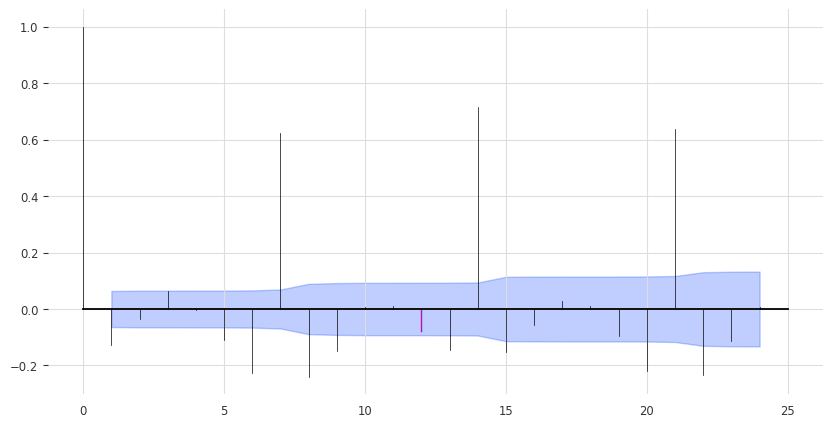

In [10]:
from darts.utils.statistics import plot_acf, check_seasonality

for m in range(4, 32):
    is_seasonal, mseas = check_seasonality(series, m=m, alpha=0.05)
    if is_seasonal:
        break

print("seasonal? " + str(is_seasonal))
if is_seasonal:
    print('There is seasonality of order {}.'.format(mseas))

plot_acf(series, m=12, alpha=0.05)

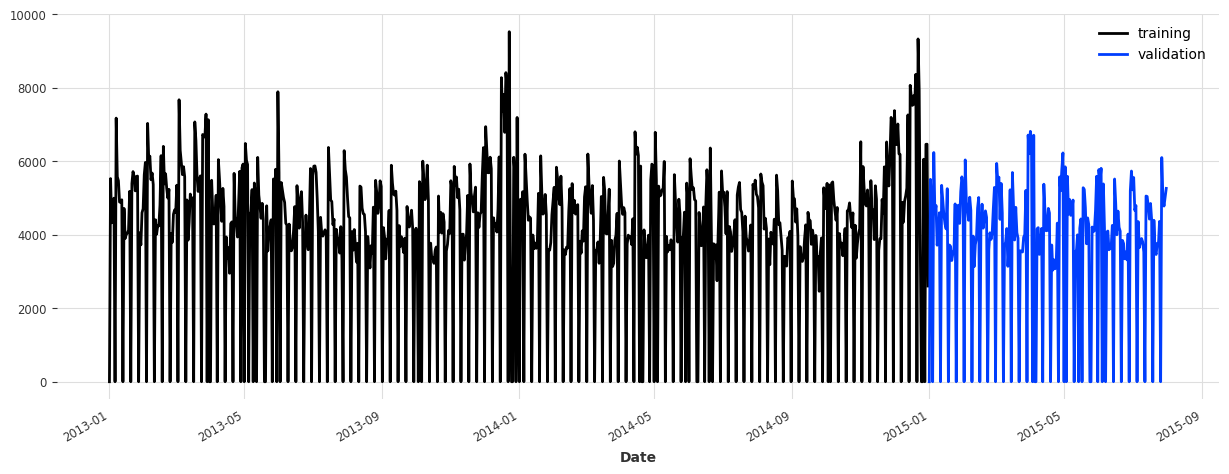

In [11]:
train, val = series.split_before(pd.Timestamp("20150101"))
train_customers, val_customers = series_customers.split_before(pd.Timestamp("20150101"))

plt.figure(figsize=(15,5))
train.plot(label="training")
val.plot(label="validation")

No matching timestamp could be found, returning original TimeSeries.


model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7 obtains MAPE: 40.62% , Training time: 0:00:00.111266
model FFT(nr_freqs_to_keep=10, trend=None) obtains MAPE: 97.69% , Training time: 0:00:00.008047


21:06:07 - cmdstanpy - INFO - Chain [1] start processing
21:06:08 - cmdstanpy - INFO - Chain [1] done processing


model Prophet obtains MAPE: 32.33% , Training time: 0:00:00.618943
model Auto-ARIMA obtains MAPE: 34.30% , Training time: 0:00:04.112472


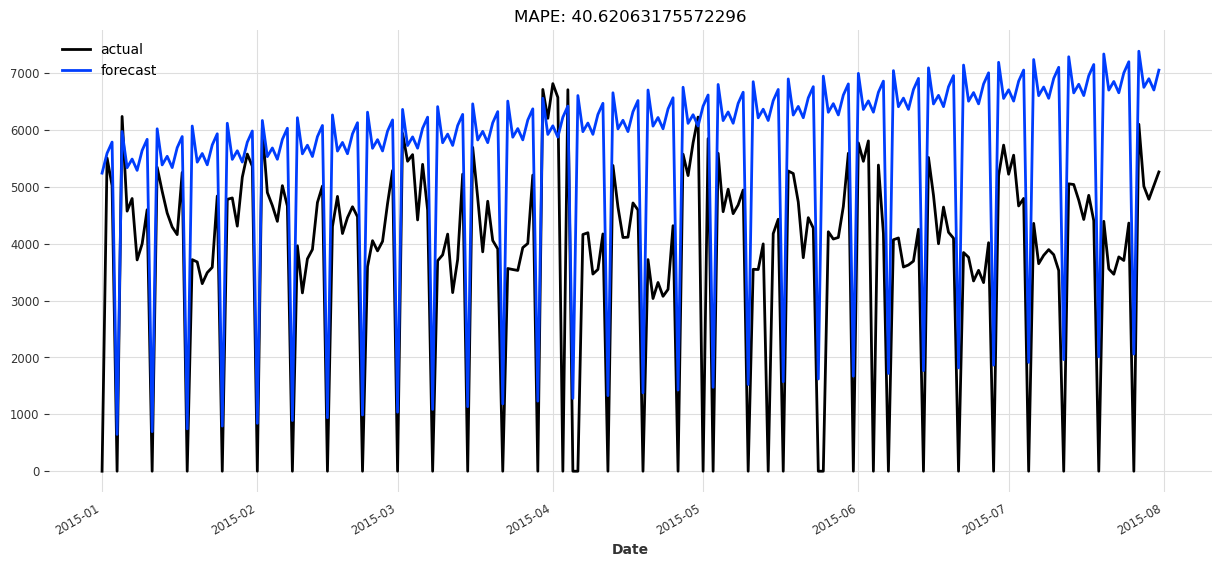

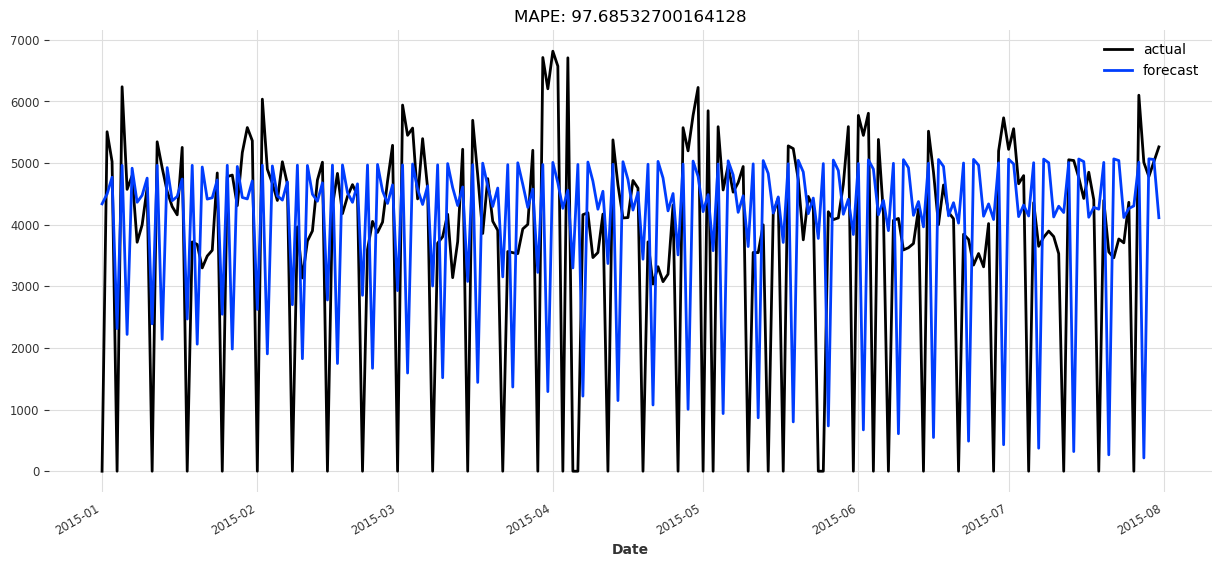

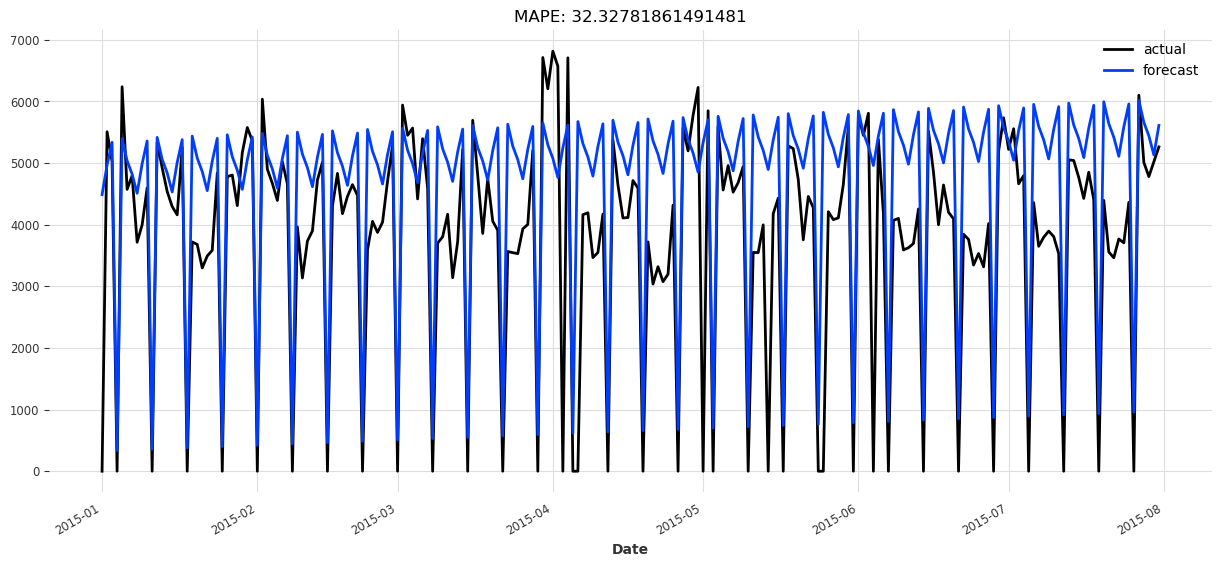

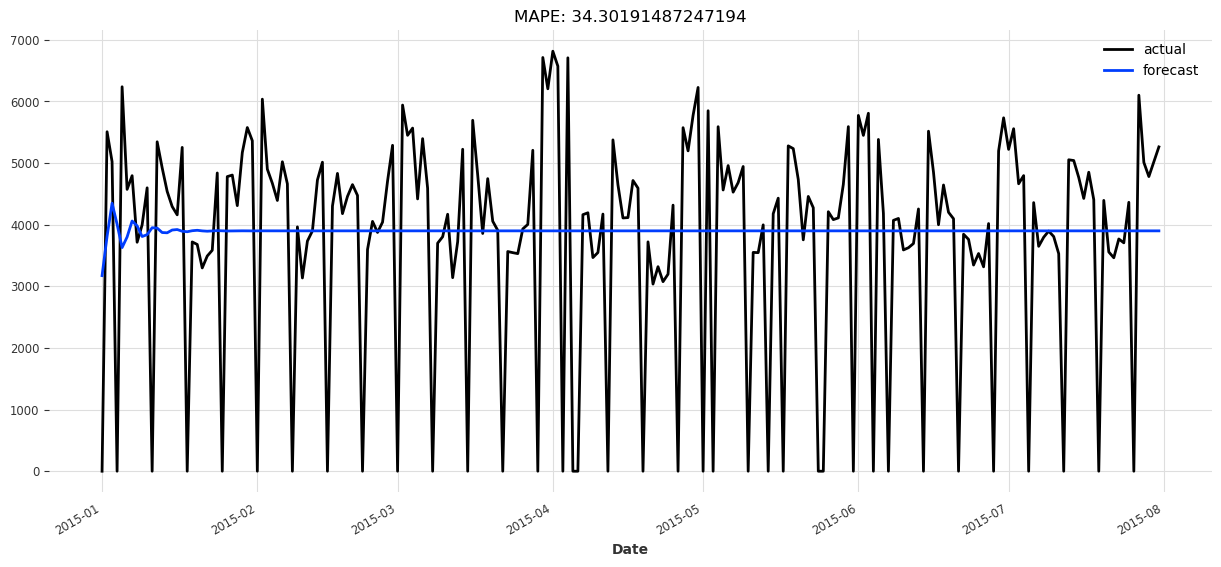

In [12]:
from darts.models import ExponentialSmoothing, FFT, Prophet, AutoARIMA, Theta
from darts.metrics import mape, r2_score

def eval_model(model, train, val):
    start_time = datetime.now() 
    model.fit(train)
    time_elapsed = datetime.now() - start_time
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}% , Training time: {}".format(model, mape(forecast, val), time_elapsed))
    plt.figure(figsize=(15, 6))
    val.plot(label="actual")
    forecast.plot(label="forecast")
    plt.title("MAPE: {}".format(mape(forecast, val)))

eval_model(ExponentialSmoothing(), train, val)
eval_model(FFT(), train, val)
eval_model(Prophet(), train, val)
eval_model(AutoARIMA(), train, val)

In [13]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'Holiday_0', 'Holiday_0', 'Holiday_a', 'Holiday_b',
       'Holiday_c'],
      dtype='object')

In [14]:
series_customers = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Customers')
series_open = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Open')
series_promo = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Promo')
series_school = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='SchoolHoliday')
series_weekday = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='DayOfWeek')
series_holiday_a = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Holiday_a')
series_holiday_b = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Holiday_b')
series_holiday_c = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Holiday_c')

In [15]:
model_future_covs = Prophet()
model_future_covs.fit(train, future_covariates=series_open)

21:06:13 - cmdstanpy - INFO - Chain [1] start processing
21:06:14 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 1.0, 'MAPE: 36.294184032327145')

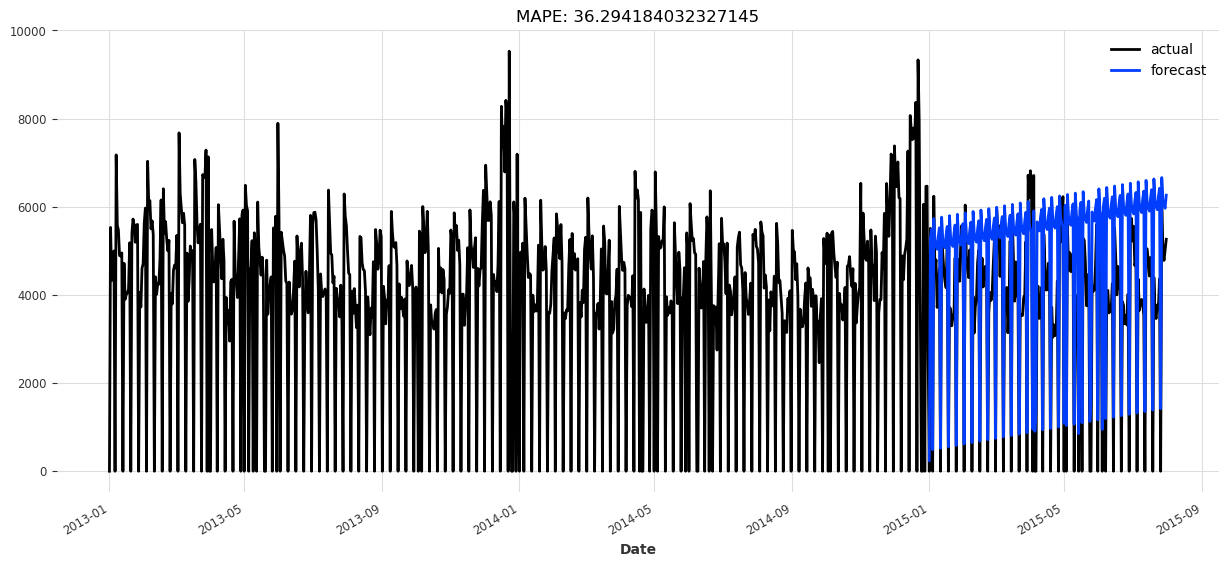

In [16]:
pred_demand_covs = model_future_covs.predict(len(val), future_covariates=series_open)

plt.figure(figsize=(15, 6))
series.plot(label="actual")
pred_demand_covs.plot(label="forecast")
plt.title("MAPE: {}".format(mape(pred_demand_covs, val)))

In [17]:
covariates = series_customers.stack(series_open)
covariates = covariates.stack(series_promo)

In [18]:
from darts.dataprocessing.transformers import Scaler
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

21:06:15 - cmdstanpy - INFO - Chain [1] start processing
21:06:15 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 1.0, 'MAPE: 21.438623469377948')

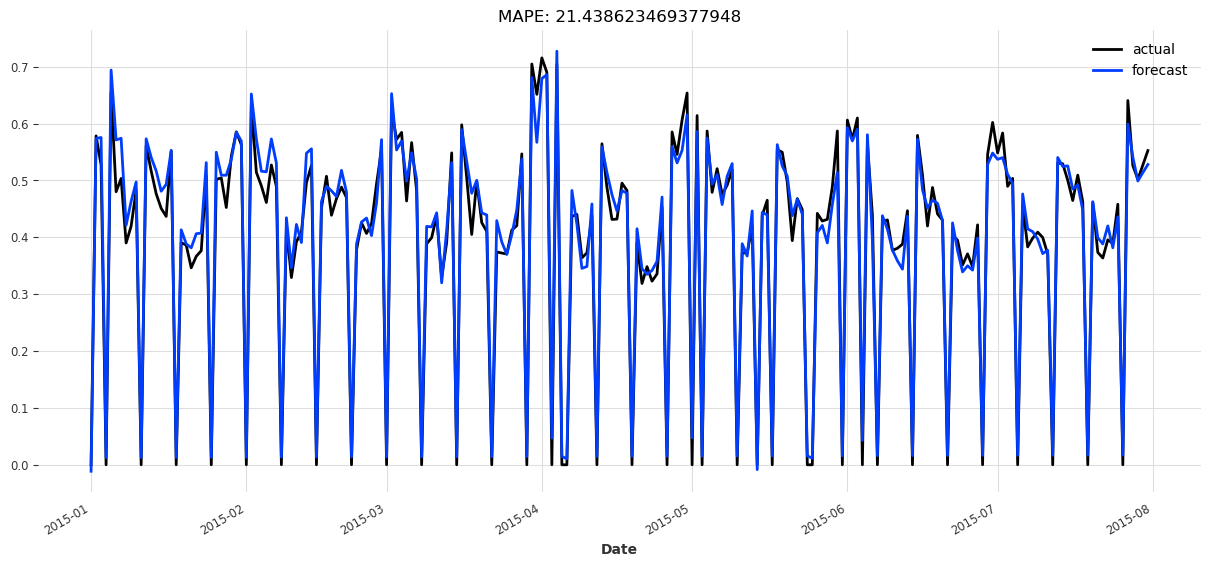

In [19]:
model_future_covs = Prophet()
model_future_covs.fit(train_transformed, future_covariates=covariates)
pred_demand_covs = model_future_covs.predict(len(val_transformed), future_covariates=covariates)

plt.figure(figsize=(15, 6))
val_transformed.plot(label="actual")
pred_demand_covs.plot(label="forecast")
plt.title("MAPE: {}".format(mape(pred_demand_covs, val_transformed)))

In [20]:
covariates = covariates.stack(series_holiday_a)
covariates = covariates.stack(series_holiday_b)
covariates = covariates.stack(series_holiday_c)
covariates = covariates.stack(series_school)

21:06:16 - cmdstanpy - INFO - Chain [1] start processing
21:06:16 - cmdstanpy - INFO - Chain [1] done processing


Text(0.5, 1.0, 'MAPE: 21.421830472289606')

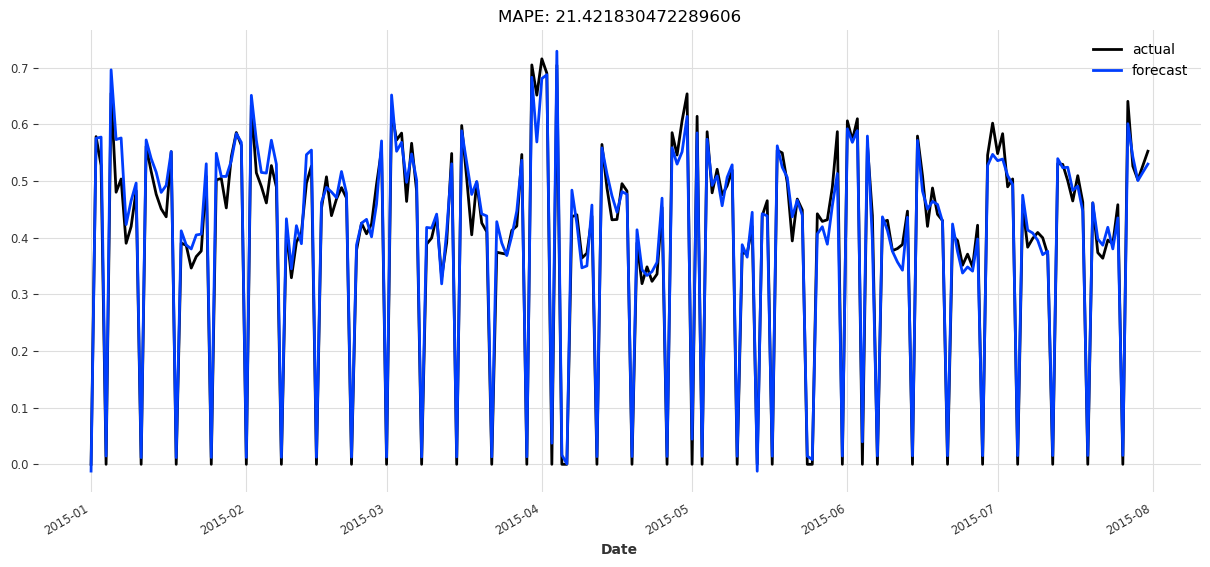

In [21]:
model_future_covs = Prophet()
model_future_covs.fit(train_transformed, future_covariates=covariates)
pred_demand_covs = model_future_covs.predict(len(val), future_covariates=covariates)

plt.figure(figsize=(15, 6))
val_transformed.plot(label="actual")
pred_demand_covs.plot(label="forecast")
plt.title("MAPE: {}".format(mape(pred_demand_covs, val_transformed)))

In [22]:
from darts.models import RNNModel
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [23]:
my_stopper = EarlyStopping(
    monitor="train_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 4.8 K 
4 | V             | Linear           | 31    
---------------------------------------------------
4.8 K     Trainable params
0         Non-trainable params
4.8 K     Total params
0.039     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Text(0.5, 1.0, 'MAPE: 22.57425680931719')

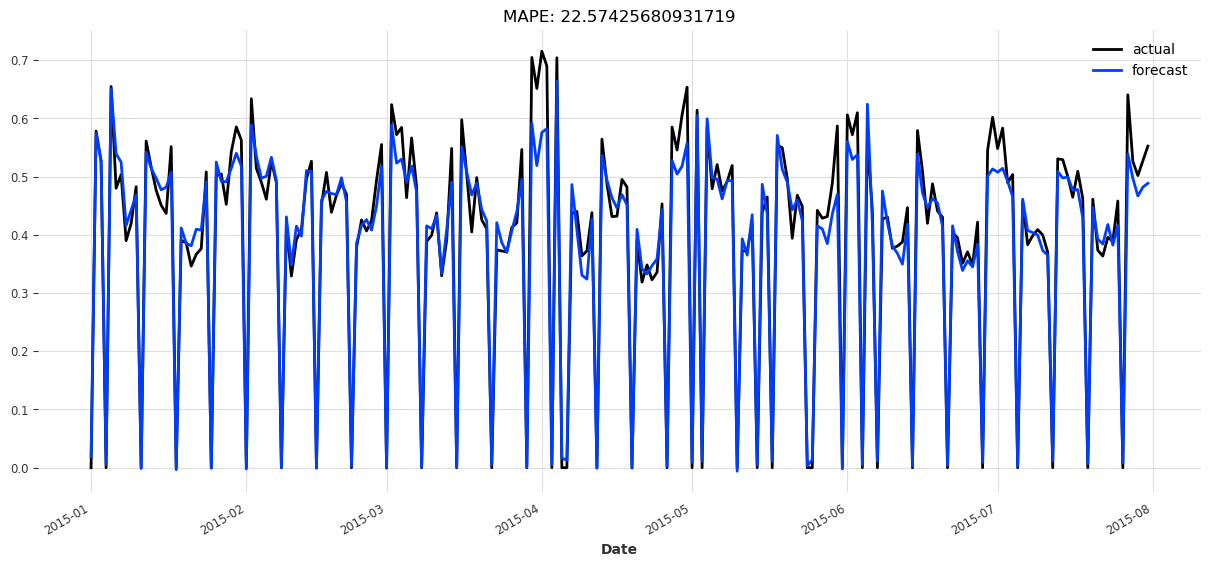

In [24]:
rnn_model = RNNModel(
    model="LSTM",
    hidden_dim=30,
    dropout=0.3,
    batch_size=16,
    n_epochs=300,
    optimizer_kwargs={"lr": 1e-3},
    model_name="rnn_sales",
    random_state=42,
    training_length=30,
    input_chunk_length=28,
    force_reset=True,
    save_checkpoints=True,
    pl_trainer_kwargs ={"accelerator": "gpu", "devices": [0],"callbacks": [my_stopper]}
)

rnn_model.fit(
    train_transformed,
    future_covariates=covariates,
    val_series=val_transformed,
    val_future_covariates=covariates,
    verbose=True,
)

pred_demand_covs = rnn_model.predict(len(val_transformed), past_covariates=covariates)

plt.figure(figsize=(15, 6))
val_transformed.plot(label="actual")
pred_demand_covs.plot(label="forecast")
plt.title("MAPE: {}".format(mape(pred_demand_covs, val_transformed)))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 4.8 K 
4 | V             | Linear           | 31    
---------------------------------------------------
4.8 K     Trainable params
0         Non-trainable params
4.8 K     Total params
0.039     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Text(0.5, 1.0, 'MAPE: 29.424966026153587')

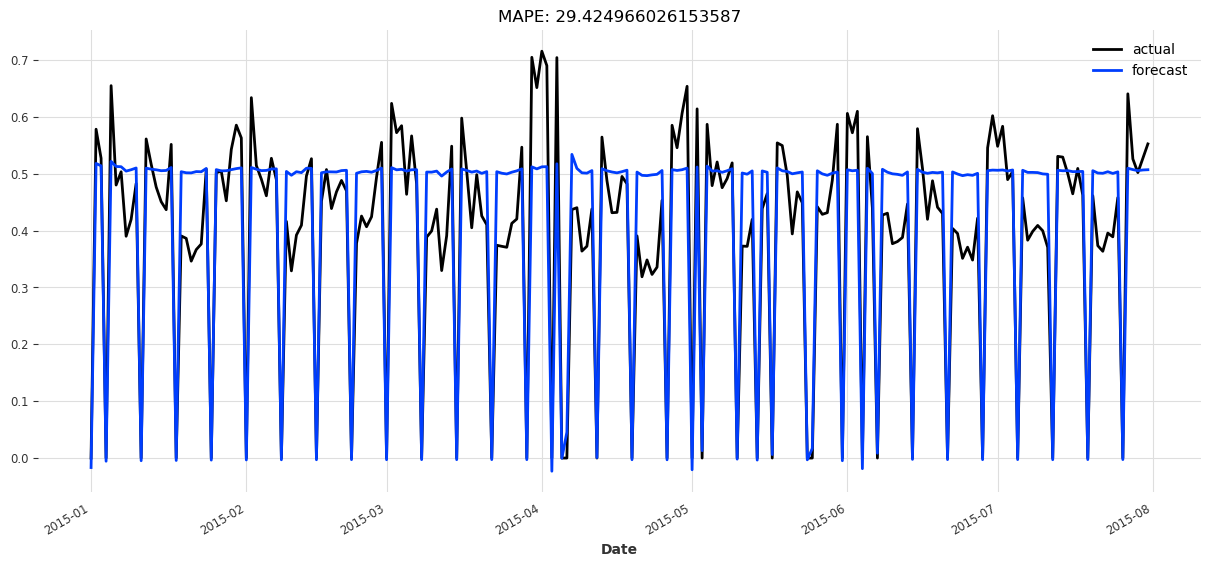

In [25]:
rnn_model = RNNModel(
    model="LSTM",
    hidden_dim=30,
    dropout=0.3,
    batch_size=16,
    n_epochs=300,
    optimizer_kwargs={"lr": 1e-3},
    model_name="rnn_sales",
    random_state=42,
    training_length=30,
    input_chunk_length=28,
    force_reset=True,
    save_checkpoints=True,
    pl_trainer_kwargs ={"accelerator": "gpu", "devices": [0],"callbacks": [my_stopper]}
)

rnn_model.fit(
    train_transformed,
    future_covariates=covariates,
    val_series=val_transformed,
    val_future_covariates=covariates,
    verbose=True,
)

pred_demand_covs = rnn_model.predict(len(val_transformed), past_covariates=covariates)

plt.figure(figsize=(15, 6))
val_transformed.plot(label="actual")
pred_demand_covs.plot(label="forecast")
plt.title("MAPE: {}".format(mape(pred_demand_covs, val_transformed)))

In [26]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries
day_series = datetime_attribute_timeseries(
    series, attribute="day", one_hot=True
)
scaler_day = Scaler()
day_series = scaler_day.fit_transform(day_series)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Text(0.5, 1.0, 'MAPE: 49.97229052773219')

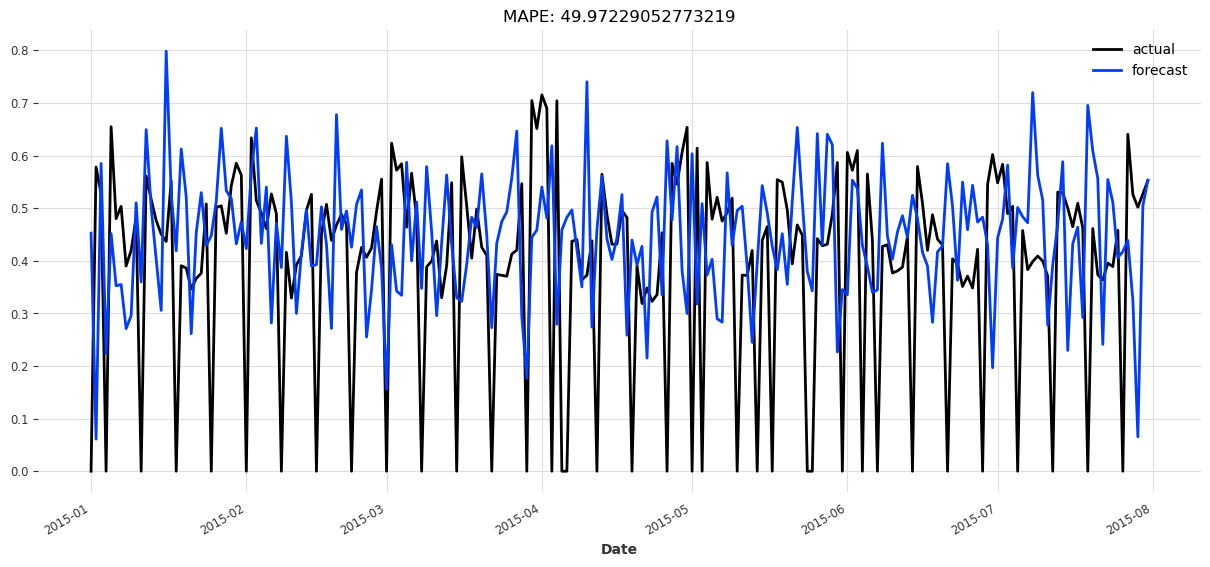

In [27]:
from darts.utils.likelihood_models import GaussianLikelihood

deeptcn = TCNModel(
    input_chunk_length=30,
    output_chunk_length=7,
    dropout=0,
    random_state=0,
    likelihood=GaussianLikelihood(),
    pl_trainer_kwargs ={"accelerator": "gpu", "devices": [0]}
)

deeptcn.fit(series=train_transformed, verbose=False)

pred_demand_covs = deeptcn.predict(len(val_transformed))

plt.figure(figsize=(15, 6))
val_transformed.plot(label="actual")
pred_demand_covs.plot(label="forecast")
plt.title("MAPE: {}".format(mape(pred_demand_covs, val_transformed)))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Text(0.5, 1.0, 'MAPE: 35.043118117831774')

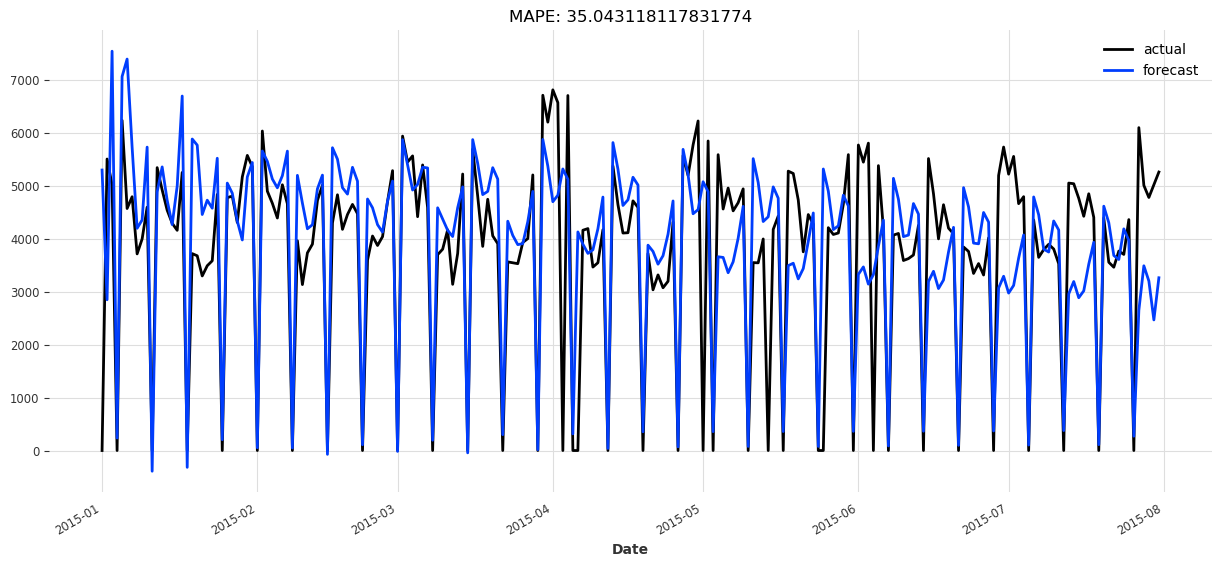

In [28]:
nbeats_model = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    pl_trainer_kwargs ={"accelerator": "gpu", "devices": [0]}
)

nbeats_model.fit(series=[train, train_customers], verbose=False)

pred_demand_covs = nbeats_model.predict(len(val), series=train)

plt.figure(figsize=(15, 6))
val.plot(label="actual")
pred_demand_covs.plot(label="forecast")
plt.title("MAPE: {}".format(mape(pred_demand_covs, val)))

In [1]:
import pandas as pd
from pytorch_lightning.callbacks import EarlyStopping
from ray import tune
from ray.tune import CLIReporter
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler
from torchmetrics import MeanAbsoluteError, MeanAbsolutePercentageError, MetricCollection

from darts.dataprocessing.transformers import Scaler
from darts.datasets import AirPassengersDataset
from darts.models import NBEATSModel

def train_model(model_args, callbacks, train, val):
    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), MeanAbsoluteError()])
    # Create the model using model_args from Ray Tune
    model = NBEATSModel(
        input_chunk_length=30,
        output_chunk_length=7,
        n_epochs=500,
        torch_metrics=torch_metrics,
        pl_trainer_kwargs={"callbacks": callbacks, "enable_progress_bar": False},
        **model_args)

    model.fit(
        series=train,
        val_series=val,
    )

# Early stop callback
my_stopper = EarlyStopping(
    monitor="val_MeanAbsolutePercentageError",
    patience=5,
    min_delta=0.05,
    mode='min',
)

# set up ray tune callback
tune_callback = TuneReportCallback(
    {
        "loss": "val_Loss",
        "MAPE": "val_MeanAbsolutePercentageError",
    },
    on="validation_end",
)

# define the hyperparameter space
config = {
    "batch_size": tune.choice([16, 32, 64, 128]),
    "num_blocks": tune.choice([1, 2, 3, 4, 5]),
    "num_stacks": tune.choice([32, 64, 128]),
    "dropout": tune.uniform(0, 0.2),
}

reporter = CLIReporter(
    parameter_columns=list(config.keys()),
    metric_columns=["loss", "MAPE", "training_iteration"],
)

resources_per_trial = {"cpu": 2, "gpu": 1}

# the number of combinations to try
num_samples = 10

scheduler = ASHAScheduler(max_t=1000, grace_period=3, reduction_factor=2)

train_fn_with_parameters = tune.with_parameters(
    train_model, callbacks=[my_stopper, tune_callback], train=train_transformed, val=val_transformed,
)

# optimize hyperparameters by minimizing the MAPE on the validation set
analysis = tune.run(
    train_fn_with_parameters,
    resources_per_trial=resources_per_trial,
    # Using a metric instead of loss allows for
    # comparison between different likelihood or loss functions.
    metric="MAPE",  # any value in TuneReportCallback.
    mode="min",
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter,
    name="tune_darts",
)

print("Best hyperparameters found were: ", analysis.best_config)

NameError: name 'train_transformed' is not defined

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Text(0.5, 1.0, 'MAPE: 32.7177823375746')

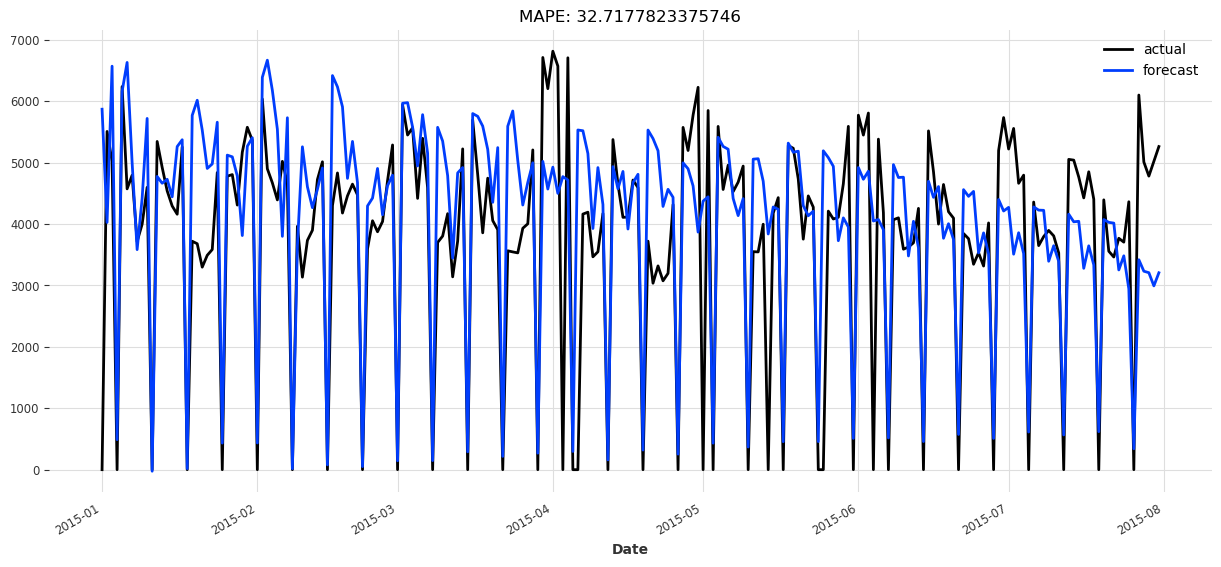

In [33]:
nbeats_model = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    batch_size=64,
    num_stacks=32,
    dropout=0.06570798989923524,
    pl_trainer_kwargs ={"accelerator": "gpu", "devices": [0]}
)

nbeats_model.fit(series=[train, train_customers], verbose=False)

pred_demand_covs = nbeats_model.predict(len(val), series=train)

plt.figure(figsize=(15, 6))
val.plot(label="actual")
pred_demand_covs.plot(label="forecast")
plt.title("MAPE: {}".format(mape(pred_demand_covs, val)))